In [1]:
import numpy as np
import h5py
import cv2
import os, sys
import argparse
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_original,watershed_per_img
from scipy.ndimage import median_filter
from skimage.metrics import *
%load_ext autoreload
%autoreload 2

In [3]:

debug = True
data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned"
for set_path in sorted(os.listdir(data_path)):
    if debug is True:
        print(set_path)
    set_path = os.path.join(data_path,set_path)
    img_list = sorted(os.listdir(set_path))
    img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
    if debug is True:
        print(img_list)
    for img_path in img_list:
        img_path = os.path.join(set_path,img_path)
        if "F32" not in img_path : # find f32 image
            print(img_path)
            continue
        
        if "F32_2.png" not in img_path:
            continue
        if debug is True:
            print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        if debug is True:
            print(img.shape)
        break
    break
        #sys.exit(-1)

SET1
['F16_1.png', 'F16_10.png', 'F16_11.png', 'F16_12.png', 'F16_13.png', 'F16_14.png', 'F16_15.png', 'F16_16.png', 'F16_2.png', 'F16_3.png', 'F16_4.png', 'F16_5.png', 'F16_6.png', 'F16_7.png', 'F16_8.png', 'F16_9.png', 'F32_1.png', 'F32_10.png', 'F32_11.png', 'F32_12.png', 'F32_13.png', 'F32_14.png', 'F32_15.png', 'F32_16.png', 'F32_2.png', 'F32_3.png', 'F32_4.png', 'F32_5.png', 'F32_6.png', 'F32_7.png', 'F32_8.png', 'F32_9.png', 'F64_1.png', 'F64_10.png', 'F64_11.png', 'F64_12.png', 'F64_13.png', 'F64_14.png', 'F64_15.png', 'F64_16.png', 'F64_2.png', 'F64_3.png', 'F64_4.png', 'F64_5.png', 'F64_6.png', 'F64_7.png', 'F64_8.png', 'F64_9.png', 'F8_1.png', 'F8_10.png', 'F8_11.png', 'F8_12.png', 'F8_13.png', 'F8_14.png', 'F8_15.png', 'F8_16.png', 'F8_2.png', 'F8_3.png', 'F8_4.png', 'F8_5.png', 'F8_6.png', 'F8_7.png', 'F8_8.png', 'F8_9.png']
/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned/SET1/F16_1.png
/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_ali

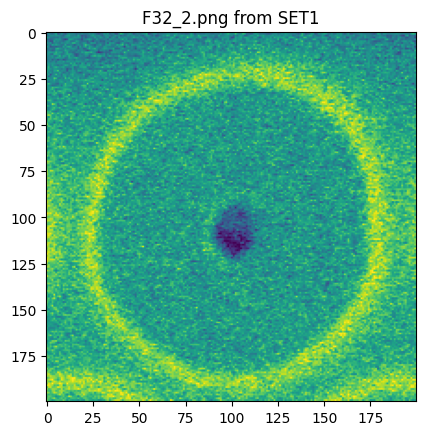

In [4]:
plt.title(f"F32_2.png from SET1")
plt.imshow(img[:200,:200])

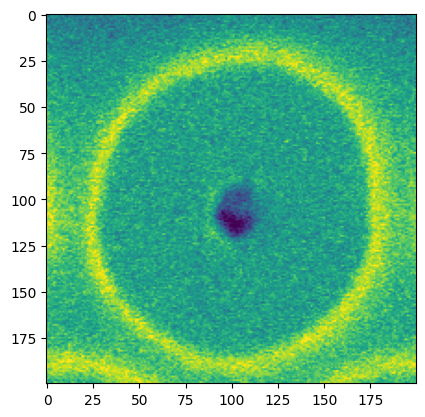

In [5]:
F64_img = cv2.imread("/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned/SET1/F64_2.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(F64_img[:200,:200])

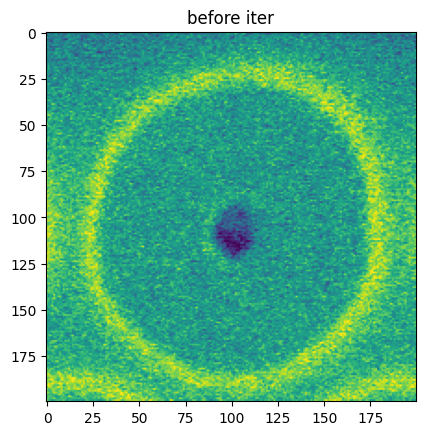

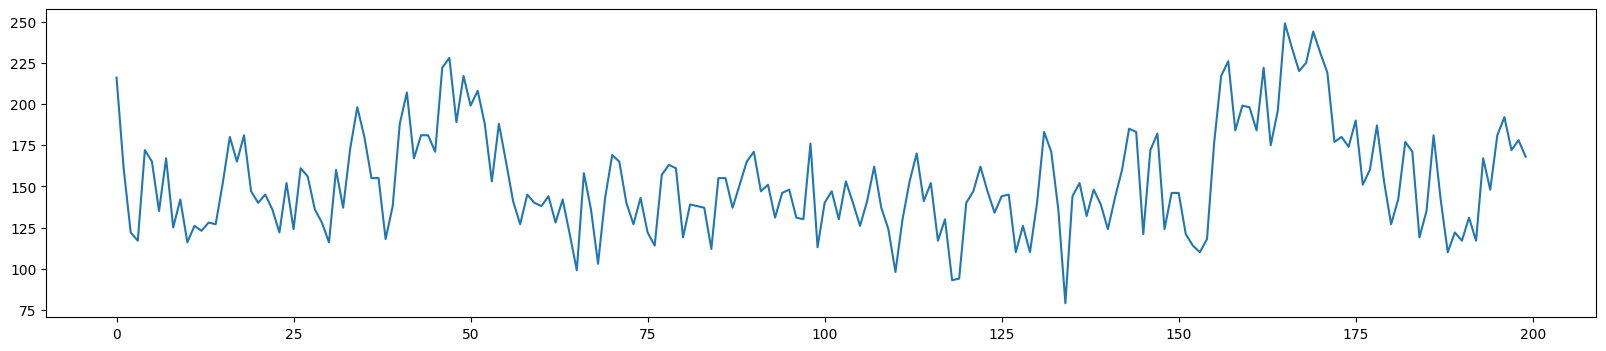

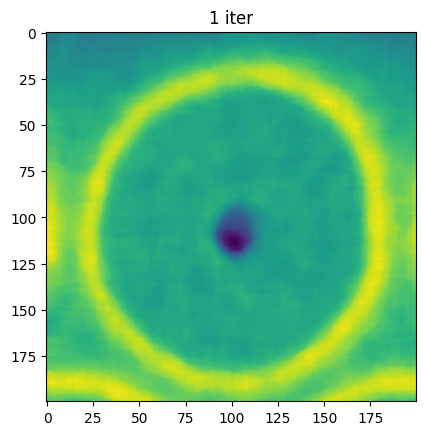

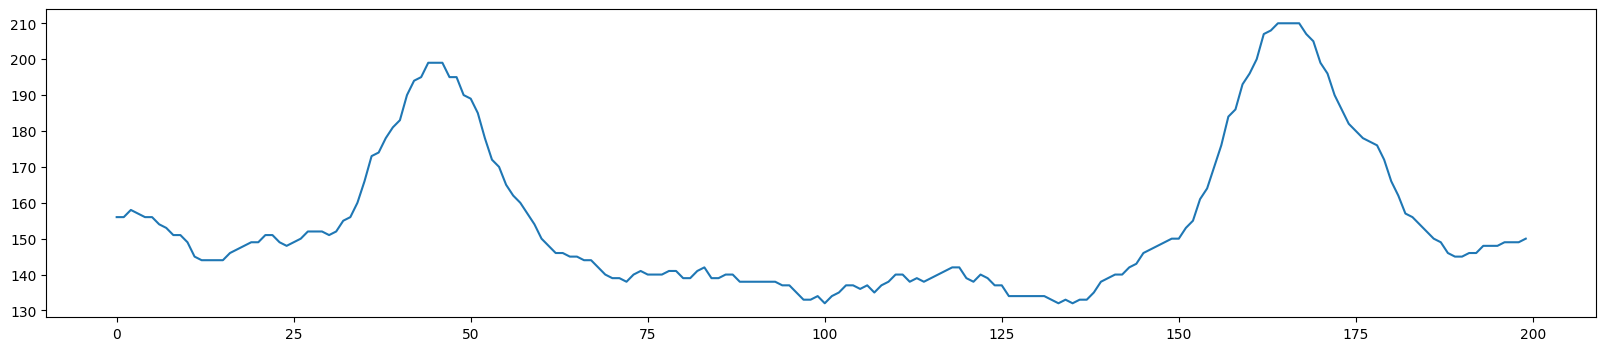

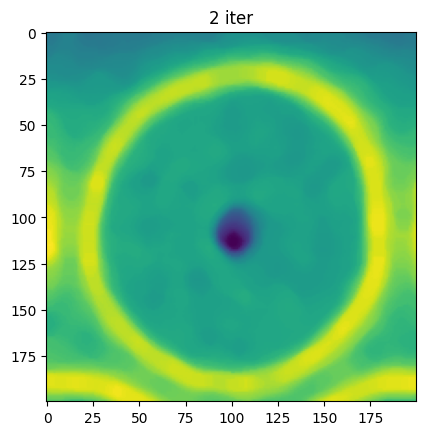

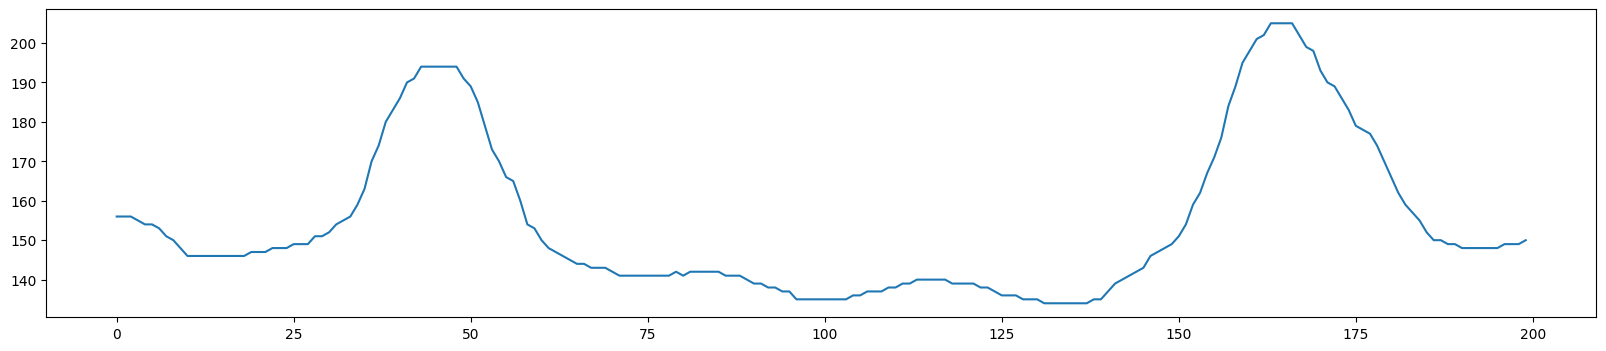

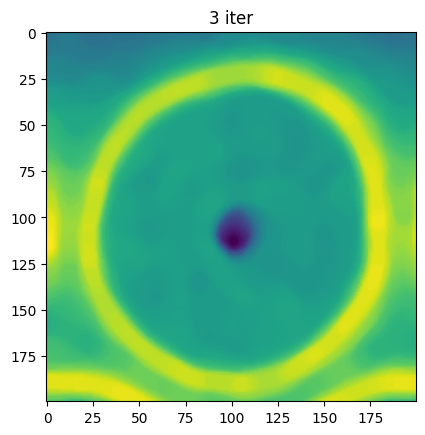

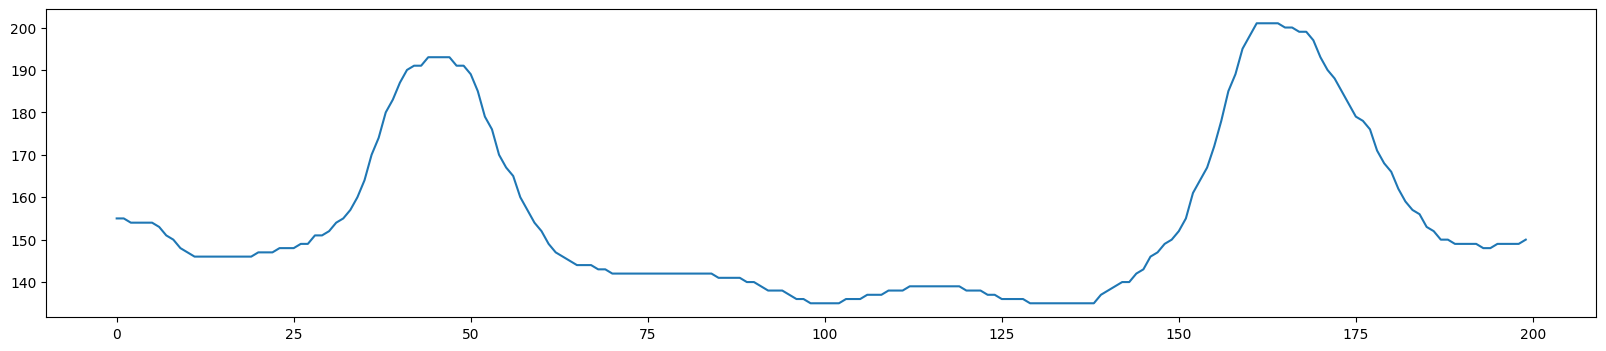

In [6]:
from copy import deepcopy
out = deepcopy(img)
plt.title(f'before iter')
plt.imshow(out[:200,:200])
plt.pause(0.01)
plt.figure(figsize=(20,4))
plt.plot(out[50][:200])
plt.pause(0.01)
for i in range(3):
    out = median_filter(out,(11,11))
    plt.title(f'{i+1} iter')
    plt.imshow(out[:200,:200])
    plt.pause(0.01)
    plt.figure(figsize=(20,4))
    plt.plot(out[50][:200])
    plt.pause(0.01)

In [7]:
F64_img.shape,img.shape,out.shape

((1474, 3010), (1474, 3010), (1474, 3010))

In [8]:
print(f"Before denoising SSIM : {structural_similarity(F64_img, img):.5f}")
print(f"Before denoising PSNR : {peak_signal_noise_ratio(F64_img, img):.5f}")
print(f"After  denoising SSIM : {structural_similarity(F64_img, out):.5f}")
print(f"After  denoising PSNR : {peak_signal_noise_ratio(F64_img, out):.5f}")


Before denoising SSIM : 0.16021
Before denoising PSNR : 18.65358
After  denoising SSIM : 0.24462
After  denoising PSNR : 21.81088


In [9]:
out.min(), out.max()

(0, 217)

In [10]:
cv2.distanceTransform?

Docstring:
distanceTransform(src, distanceType, maskSize[, dst[, dstType]]) -> dst
.   @overload
.   @param src 8-bit, single-channel (binary) source image.
.   @param dst Output image with calculated distances. It is a 8-bit or 32-bit floating-point,
.   single-channel image of the same size as src .
.   @param distanceType Type of distance, see #DistanceTypes
.   @param maskSize Size of the distance transform mask, see #DistanceTransformMasks. In case of the
.   #DIST_L1 or #DIST_C distance type, the parameter is forced to 3 because a \f$3\times 3\f$ mask gives
.   the same result as \f$5\times 5\f$ or any larger aperture.
.   @param dstType Type of output image. It can be CV_8U or CV_32F. Type CV_8U can be used only for
.   the first variant of the function and distanceType == #DIST_L1.
Type:      builtin_function_or_method


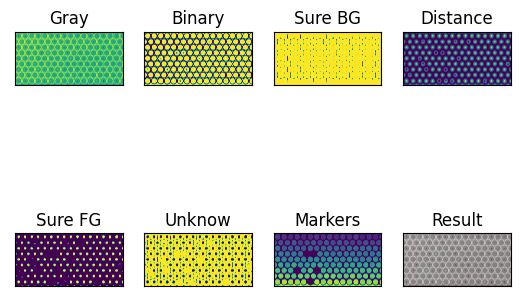

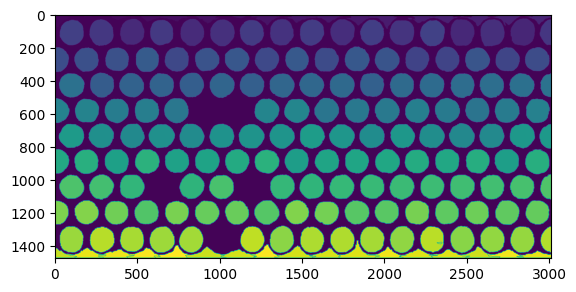

In [11]:
# https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
import cv2
import numpy as np
from matplotlib import pyplot as plt


# img = cv2.imread('images/watershed.jpg')

gray = out
b = np.zeros((out.shape[0],out.shape[1],3)).astype('uint8')
b[:,:,0] = out
b[:,:,1] = out
b[:,:,2] = out

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
# kernel = np.ones((3,3),np.uint8)
kernel = np.ones((11,11),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=3)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=4)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknown영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(b,markers)
b[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, b]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()
plt.imshow(markers)

In [12]:
new_out = deepcopy(out)

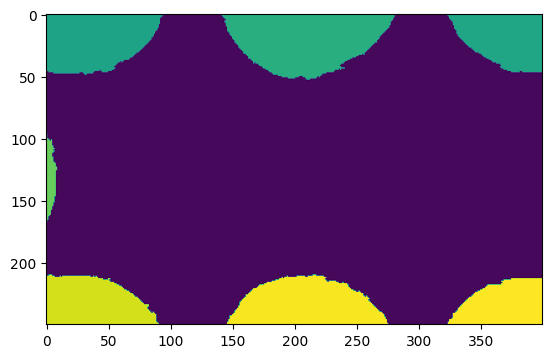

In [33]:
plt.imshow(markers[450:700,800:1200])

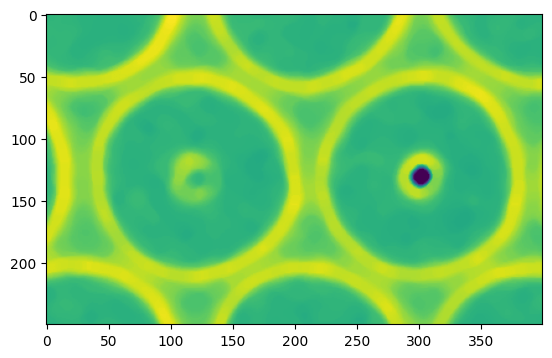

In [13]:
plt.imshow(new_out[450:700,800:1200])

In [18]:
new_out[550:700,850:1200][:50,50:100] = np.median(new_out[550:700,850:1200][:50,50:100])
new_out[550:700,850:1200][:60,230:270] = np.median(new_out[550:700,850:1200][:60,230:270])

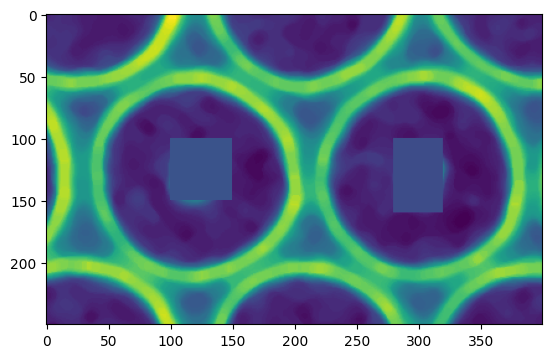

In [30]:
# plt.imshow(new_out[550:700,850:1200])
plt.imshow(new_out[450:700,800:1200])

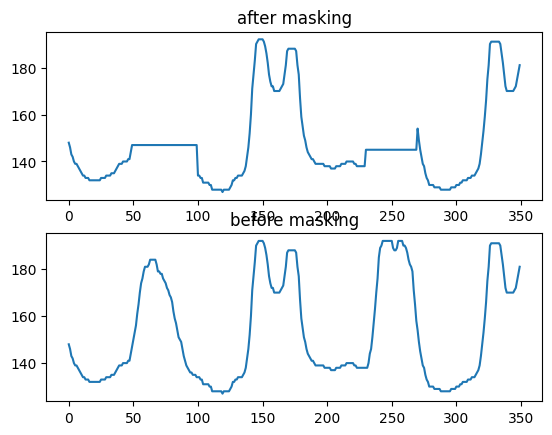

In [31]:
plt.subplot(211)
plt.title("after masking")
plt.plot(new_out[570,850:1200])
plt.subplot(212)
plt.title("before masking")
plt.plot(out[570,850:1200])

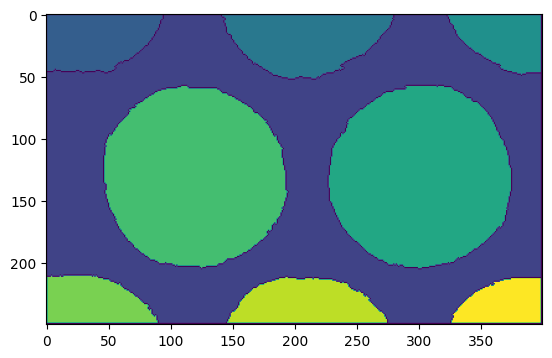

In [21]:
r = watershed_original(new_out[450:700,800:1200])
plt.imshow(r)

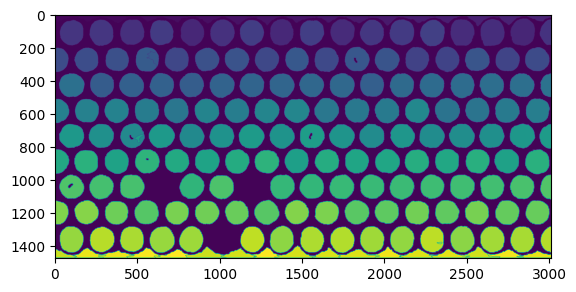

In [29]:
r = watershed_original(new_out)
plt.imshow(r)

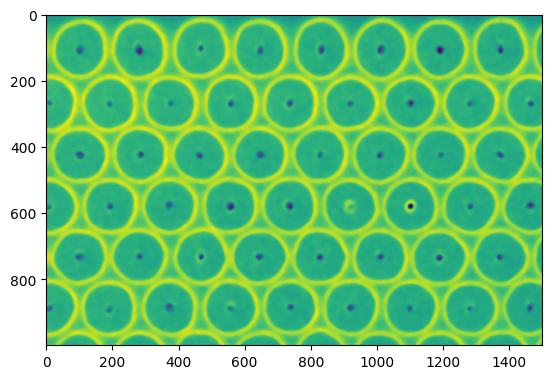

In [22]:
plt.imshow(out[:1000,:1500])

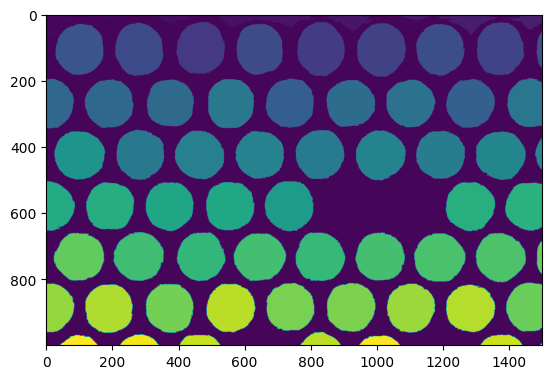

In [23]:
plt.imshow(markers[:1000,:1500])

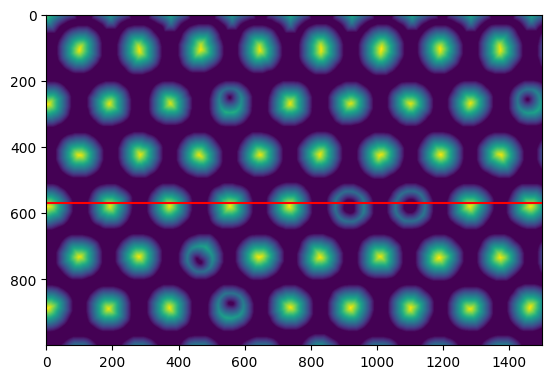

In [24]:
plt.imshow(dist_transform[:1000,:1500])
plt.axhline(570,color='r')

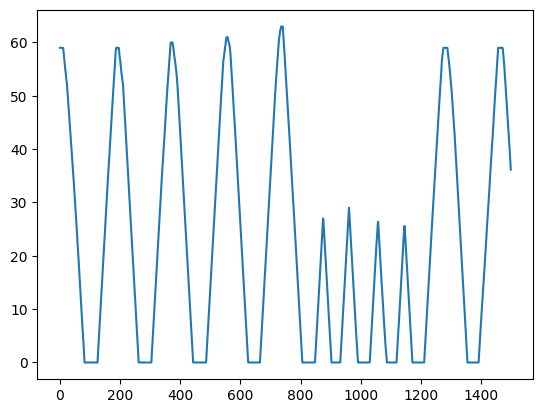

In [25]:
plt.plot(dist_transform[:1000,:1500][570])

/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 24

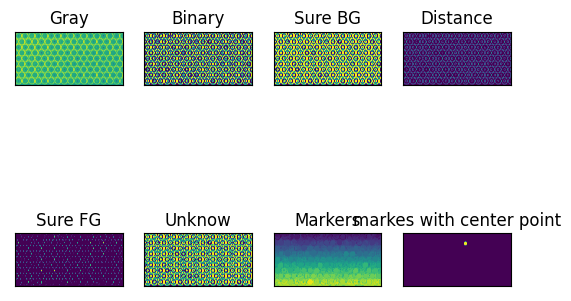

In [26]:
#print(img_name)
r = watershed(out,0,True) #  

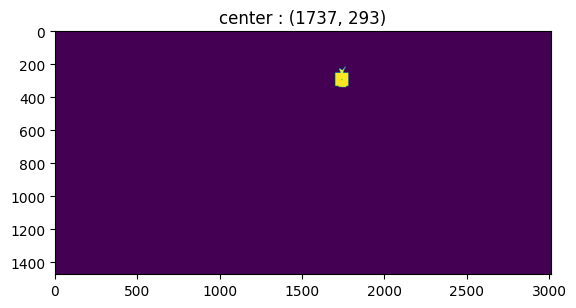

In [27]:
plt.title(f"center : {r[0]}")
plt.imshow(r[-1])#[:200,:200])

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
cricle_value is 255
-1 -1


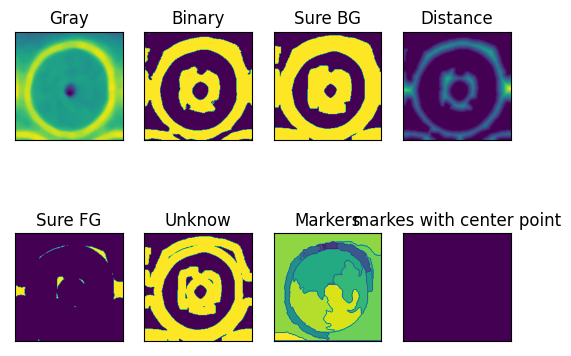

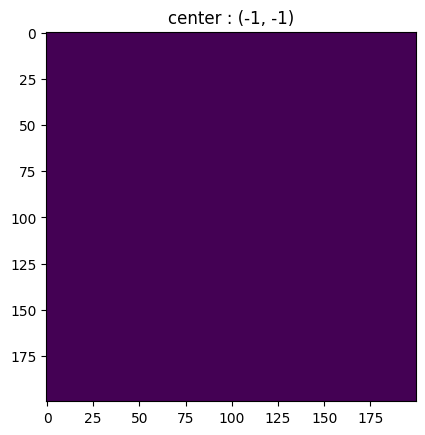

In [28]:
subset_r = watershed(out[:200,:200],0,True)
plt.title(f"center : {subset_r[0]}")
plt.imshow(subset_r[-1])#[:200,:200])